In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import json
import os

In [97]:
# %cd ..

In [98]:
config_path = 'data/Heino_test/output_20240829_164635/voxel_resolution15_area9/config.json'

In [99]:
with open(config_path, 'r') as file:
    CONFIG = json.load(file)
    print(CONFIG)

{'area_per_point': 9, 'azimuth_resolution': 5, 'elevation_resolution': 5, 'epw_file': 'heino.epw', 'global_irradiance_time': 1834.2714636325836, 'irradiance_batch_size': 500, 'irradiance_model': 'isotropic', 'num_bounces': 5, 'output_folder_name': 'output_20240829_164635', 'result': {'bbox_max': [215605.0, 495792.5, 17.389999389648438], 'bbox_min': [212940.0, 493127.5, 1.1240005493164062], 'global_irradiance_time': 7464.800040245056, 'num_timesteps': 12, 'shadow_calculation_time': 0.1298115998506546, 'viewshed_rendering_time': 32.54604721069336, 'voxel_dim_x': 178, 'voxel_dim_y': 178, 'voxel_dim_z': 2}, 'study_area': {'data_root': './data/Heino_test', 'end_time': '2020-03-22 00:00:00', 'frequency': 'h', 'lat': 52.43393735045974, 'long': 6.261741696877466, 'start_time': '2020-03-21 00:00:00', 'timezone': 'Europe/Amsterdam'}, 'voxel_resolution': 15}


In [100]:
folder_path = CONFIG['study_area']['data_root']
data_root = os.path.join(folder_path, CONFIG['output_folder_name'])
point_grid_path = os.path.join(data_root, 'intermediate', 'point_grid.dat')
index_map_path = os.path.join(data_root,  'index_map.dat')
shadow_map_path = os.path.join(data_root, 'shadow_map.dat')


horizon_factor_path = os.path.join(data_root, 'horizon_factor_map.dat')
sky_view_factor_path = os.path.join(data_root,  'sky_view_factor_map.dat')
cosine_map_path = os.path.join(data_root, 'cosine_map.dat')

voxel_size = CONFIG['voxel_resolution']
num_azimuth = 360//CONFIG['azimuth_resolution']
num_elevation = 90//CONFIG['elevation_resolution']
print(num_azimuth, num_elevation)
num_samples = num_azimuth*num_elevation
index_dim = (num_elevation,num_azimuth)

estimated_irradiance_path = os.path.join(data_root, 'voxel_resolution15_area9', 'irradiance.npy')
weather_data_path = os.path.join(data_root,'voxel_resolution15_area9', 'weather_data.npy')

72 18


In [101]:
point_grid = np.loadtxt(point_grid_path)
estimated_irradiance = np.load(estimated_irradiance_path)
weather_data = np.load(weather_data_path)

In [102]:
def print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, point_idx):
    horizon_factor_path = np.memmap(horizon_factor_path, dtype=np.float16, mode='r')
    sky_view_factor_path = np.memmap(sky_view_factor_path, dtype=np.int32, mode='r')
    index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
    # cosine_map = np.memmap(cosine_map_path, dtype=np.float16, mode='r')

    num_samples = index_dim[0]*index_dim[1]
    index_start = point_idx*num_samples
    index_end = (point_idx+1)*num_samples

    voxel_indices = index_map[index_start:index_end]
    # breakpoint()
    voxel_indices = voxel_indices.reshape(index_dim)
    unique_values = np.unique(voxel_indices)

    # sum_of_cosine = np.sum(cosine_map[index_start*6:index_end*6])
    # print("sum of cosine: ", sum_of_cosine)

    # 创建一个随机颜色映射，确保白色为最大值对应的颜色
    colors = {}
    for value in unique_values:
        # print(value)
        if value == 4294967295:
            colors[value] = (1.0, 1.0, 1.0)  # 白色
        else:
            colors[value] = (random.random(), random.random(), random.random())

    # 将图像数据转换为 RGB
    image = np.zeros((voxel_indices.shape[0], voxel_indices.shape[1], 3))

    for i in range(voxel_indices.shape[0]):
        for j in range(voxel_indices.shape[1]):
            image[i, j] = colors[voxel_indices[i, j]]

    image = np.flipud(image)
    plt.xticks(np.linspace(0, voxel_indices.shape[1] - 1, num=5), 
           labels=np.linspace(0, 360, num=5).astype(int))  # 横轴 azimuth 从 0 到 360 度

    plt.yticks(np.linspace(0, voxel_indices.shape[0] - 1, num=4), 
            labels=np.linspace(90, 0, num=4).astype(int))  # 纵轴 elevation 从 0 到 90 度

    # 添加坐标轴标签
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Elevation (degrees)')

    plt.imshow(image)
    plt.savefig('BK.png', bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

    print("sky view factor: ", sky_view_factor_path[point_idx]/num_samples)
    print("horizon factor: ", horizon_factor_path[point_idx])
    formatted_values = [f"{x:.5f}" for x in point_grid[point_idx]]
    print("point info: ", formatted_values)

    



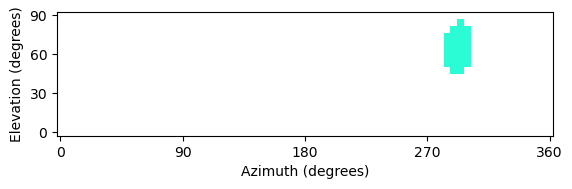

sky view factor:  0.9799382716049383
horizon factor:  0.0
point info:  ['214284.00000', '494443.00000', '5.05800', '0.00000', '0.00000', '1.00000', '0.10000', '1.00000', '1539012.00000']


In [103]:
# idx= 720495# weatherstation area 25
idx = 1539012 # weatherstation area 9
# idx = 237027 # random bk
print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, idx)

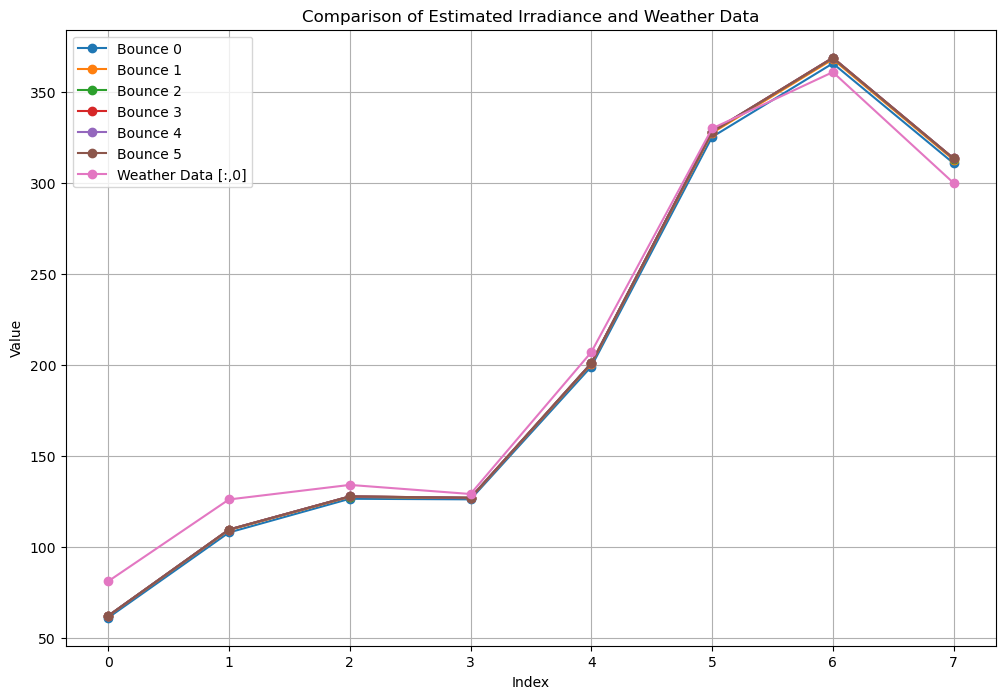

In [105]:
plt.figure(figsize=(12, 8))

for i in range(6):
    plt.plot(estimated_irradiance[i][idx][0:8], label=f"Bounce {i}", marker='o')


plt.plot(weather_data[:,0][0:8], label="Weather Data [:,0]", marker='o')

plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Comparison of Estimated Irradiance and Weather Data")
plt.legend()
plt.grid(True)
plt.savefig('Heino_9_5_15.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()